In [3]:
import sys
sys.path.insert(1, '..')
from utils import *

%matplotlib inline

In [4]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'
network_dir = join(pwd, dpath, 'mobility-networks', f'{AREA_NAME}-CBG-CBG-Nets-msa')
nets = load_networks(network_dir)

100%|██████████| 107/107 [00:21<00:00,  4.88it/s]


### Census Attributes

In [5]:
area_cbgs = get_CBGS(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)

In [6]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [7]:
def get_census_attrs(rank_list=[]):
    '''
    reads and prepares the census attributes
    `rank_list` stores the attributes to be worked as ranked values
    '''
    census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
    census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

    commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
    census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

    edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
    census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

    census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
    census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

    col_names = ['income', 'total_population', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
    quart = ['Bottom', 'Third', 'Second', 'Top']
    for col in col_names:
        census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

    census_quartiles = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
    census_raw_values = census_attrs[['census_block_group', *col_names]]
    
    for attr in rank_list:
        census_raw_values[attr] = census_raw_values[attr].rank(pct=True)
    
    return census_quartiles, census_raw_values

In [8]:
zcta_df = pd.read_csv(join(pwd, 'util_datasets', 'bg-zip-pop2.csv'))
zcta_df['BG GEO-ID'] = zcta_df['BG GEO-ID'].str[1:]
zcta_df['BG GEO-ID'] = zcta_df['BG GEO-ID'].astype(np.int64)
zcta_df = zcta_df[zcta_df['BG GEO-ID'].isin(set(area_cbgs))]
zcta_df['cbg_ratio'] = zcta_df['BG Population Part in Zip'] / zcta_df['Zip Population']
zcta_df = zcta_df.set_index('BG GEO-ID')

In [9]:
case_df = pd.read_csv(join(pwd, 'util_datasets', 'nyc-weekly-cases.csv'))
weeks = np.sort(pd.to_datetime(case_df.Date).unique())

In [10]:
rows = []
for cbg in tqdm(zcta_df.index.unique()):
    zip_codes = zcta_df.loc[[cbg]][['ZipCode', 'cbg_ratio']]
    filtered_df = case_df[case_df.ID.isin(zip_codes['ZipCode'].values)]
    r = pd.merge(zip_codes, filtered_df, left_on='ZipCode', right_on='ID')
    r['Norm_Cases'] = r['Cases_New'] * r['cbg_ratio']
    r = r.groupby('Date')[['Norm_Cases']].sum().reset_index()
    r['cbg'] = cbg
    rows.append(r)

100%|██████████| 6252/6252 [00:16<00:00, 389.81it/s]


In [11]:
cases_df = pd.concat(rows, axis=0)

In [12]:
cases_df.to_csv(join(pwd, 'util_datasets', 'nyc-cases-by-cbgs.csv'), index=False)

### Staten Island Mobility

In [13]:
staten_island_cbgs = pd.read_csv(join(pwd, 'util_datasets', 'staten_island_cbgs.csv')).astype(str).values.flatten()

In [14]:
nyc_cbg_shp = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-cbgs.json'))

In [15]:
nyc_cbg_shp.COUNTYFP.unique()

array(['081', '005', '085', '061', '047'], dtype=object)

In [16]:
fp2name = {
    '081': 'Queens',
    '005': 'Bronx',
    '085': 'Staten Island',
    '061': 'Manhattan',
    '047': 'Brooklyn' 
}

borough_cbgs = {}

In [17]:
for borough_code, ind in nyc_cbg_shp.groupby('COUNTYFP').groups.items():
    borough_cbgs[fp2name[borough_code]] = nyc_cbg_shp.loc[ind, 'GEOID'].astype(str).values

In [46]:
def get_borough_mobility(borough_cbgs, networks, self_loop_ratio=False, loops=False):
    '''
    returns the sum of out-degree edges from the CBGs of the given borough from the set of networks
    '''
    mob = []
    for tnet in networks:
        cnet = tnet[1]
        common_cbgs = np.intersect1d(cnet.vs['name'], borough_cbgs)
        if not self_loop_ratio:
            mob.append(np.sum(cnet.strength(common_cbgs, loops=loops, mode='out', weights='visits')))
        else:
            self_visits = np.subtract(cnet.strength(common_cbgs, loops=True, mode='in', weights='visits'), 
                                      cnet.strength(common_cbgs, mode='in', loops=False, weights='visits'))
            out_visits = np.array(cnet.strength(common_cbgs, loops=False, mode='out', weights='visits'))
            total_visits = self_visits + out_visits + 0.001

            mob.append(np.mean(self_visits/total_visits))

    return np.array(mob) #pd.Series(mob, index=[net[0] for net in networks])

In [47]:
borough_cols = {}
for borough, cbgs in borough_cbgs.items():
    borough_cols[borough] = get_borough_mobility(cbgs, nets, self_loop_ratio=True, loops=True)
    
borough_mob_df = pd.DataFrame(borough_cols, index=[net[0] for net in nets])

In [50]:
borough_mob_df.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2018-12-31,0.090378,0.080562,0.104002,0.070662,0.052567
2019-01-07,0.088388,0.079502,0.106417,0.069648,0.052571
2019-01-14,0.093437,0.082418,0.108827,0.074357,0.056223
2019-01-21,0.099885,0.087911,0.115693,0.076451,0.057587
2019-01-28,0.104380,0.091269,0.121796,0.079895,0.059989


In [48]:
ind_date = datetime(2020, 1, 13)

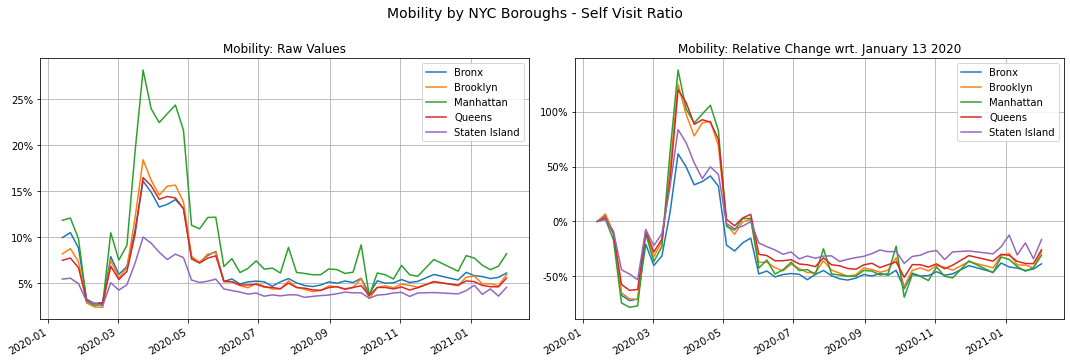

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

selected_time = borough_mob_df.loc[ind_date:]

ax = axes[0]
selected_time.plot(ax=ax)
ax.grid()
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y/1000:.0f}K'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.set_title('Mobility: Raw Values')

ax = axes[1]
selected_time.div(selected_time.iloc[0]).plot(ax=ax)
ax.grid()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{(y-1)*100:.0f}%'))
ax.set_title(f'Mobility: Relative Change wrt. {ind_date.strftime("%B %d %Y")}')

fig.suptitle('Mobility by NYC Boroughs - Self Visit Ratio', y=1.0, fontsize=14)
plt.tight_layout()

fig.savefig(join(FIG_SAVE_DIR, 'nyc-mobility_by_boroughs_self_visit_ratio.png'), bbox_inches='tight')

In [ ]:
feature_names = ['income-quartile', 'white_population-quartile', 'black_population-quartile', 'asian_population-quartile',
                'hispanic_population-quartile', 'education-quartile', 'mean_time_to_work-quartile']

qnumeric = {'Top': 4, 'Second': 3, 'Third': 2, 'Bottom': 1}
vec = census_quartiles[census_quartiles['census_block_group'].isin(vals.index)][feature_names].reset_index(drop=True)
vec.replace(qnumeric, inplace=True)

vec = pd.DataFrame(stats.zscore(vec.values, nan_policy='omit'), columns=feature_names)
y = pd.Series(stats.zscore(vals.values, nan_policy='omit'), name='Hotspot Occurrences')
X = sm.add_constant(vec)
result = sm.OLS(y, X, missing='drop').fit()

with open(join(reg_dir, 'hotspot-occurrences-allfeatures-nonSI-noelection.txt'), 'w') as f:
    f.write(result.summary().as_text())

### Borough Subgraphs

In [22]:
borough_net_sum_dfs = {}
for borough, cbgs in borough_cbgs.items():
    
    print(borough)
    
    features = dict(n_edges = [],
            mean_in_deg = [],
            mean_out_deg = [],
            mean_total_deg = [],
            mean_wdeg = [],
            diameter = [],
            clustering_coef = [],
            mean_path_len = [],
            density = [],
            local_clustering = [])

    
    for tnet in nets:
        cnet = tnet[1]
        common_cbgs = np.intersect1d(cnet.vs['name'], cbgs)
        cnet = cnet.subgraph(common_cbgs)
        
        features['n_edges'].append(len(cnet.es))
        features['mean_in_deg'].append(np.nanmean(ig.Graph.degree(cnet, mode='in')))
        features['mean_out_deg'].append(np.nanmean(ig.Graph.degree(cnet, mode='out')))
        features['mean_total_deg'].append(np.nanmean(ig.Graph.degree(cnet, mode='all')))
        features['mean_wdeg'].append(np.nanmean(ig.Graph.degree(cnet, mode='all')) / len(cnet.vs))
        features['diameter'].append(ig.Graph.diameter(cnet, directed=True, unconn=cnet.is_connected()))
        features['density'].append(ig.Graph.density(cnet, loops=True))
        features['clustering_coef'].append(ig.Graph.transitivity_undirected(cnet))
        features['mean_path_len'].append(ig.Graph.average_path_length(cnet, directed=True, unconn=cnet.is_connected()))
        features['local_clustering'].append(np.nanmean(ig.Graph.transitivity_local_undirected(cnet, weights='weight')))
        
    borough_net_sum_dfs[borough] = pd.DataFrame(features, index=[tnet[0] for tnet in nets])

Bronx
Brooklyn
Manhattan
Queens
Staten Island


In [40]:
feature_titles = {
    'n_edges': 'Number of Edges',
    'mean_in_deg': 'Mean In Degree',
    'mean_out_deg': 'Mean Out Degree',
    'mean_total_deg': 'Mean Total Degree',
    'mean_wdeg': 'Mean Weighted Degree',
    'diameter': 'Diameter',
    'density': 'Density',
    'clustering_coef': 'Global Clustering Coefficient',
    'local_clustering': 'Mean Local Clustering Coefficient',
    'mean_path_len': 'Mean Path Length'
}

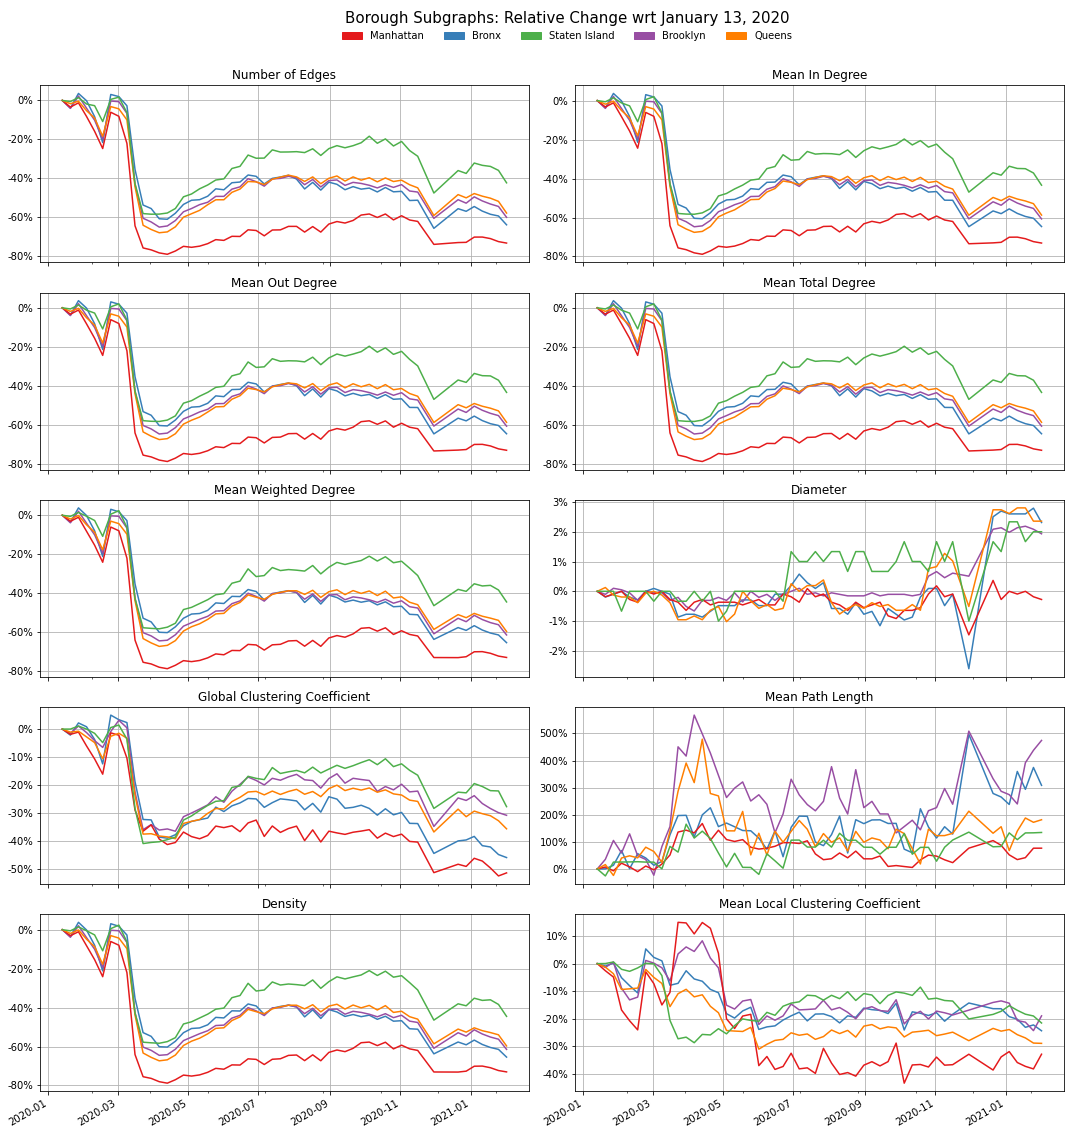

In [76]:
sel_date = datetime(2020, 1, 13)
feature_names = list(features.keys())

bcolors = {
    'Manhattan': '#e41a1c',
    'Bronx': '#377eb8',
    'Staten Island': '#4daf4a',
    'Brooklyn': '#984ea3',
    'Queens': '#ff7f00'
}

fig, axes = plt.subplots(5, 2, figsize=(15, 15), sharex=True)

for f, ax in zip(feature_names, axes.flatten()):
    for borough in borough_net_sum_dfs.keys():
        sel_reg = borough_net_sum_dfs[borough].loc[sel_date:]
        #sel_reg[f].plot(ax=ax, color=bcolors[borough])
        relative_chg = sel_reg[f] / sel_reg[f][0]
        relative_chg.plot(ax=ax, color=bcolors[borough])
    ax.grid()
    ax.set_title(feature_titles[f])
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{(y-1)*100:.0f}%'))
    
patch = []
for br, cl in bcolors.items():
    patch.append((br, mpatches.Patch(color=cl)))

lgd = fig.legend([i[1] for i in patch],
                   [i[0] for i in patch],
                   loc="center",
                   ncol=5,
                   bbox_to_anchor=(0.53, 1.03), 
                   title_fontsize=15,
                   title=f'Borough Subgraphs: Relative Change wrt {sel_date.strftime("%B %d, %Y")}', 
                   edgecolor='white')
fig.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, 'nyc-borough-subgraph-net-summary-relative-change.png'), bbox_inches='tight')

### Bridge CBGs

In [18]:
covid_case_ranks = []

In [19]:
census_quartiles, census_values = get_census_attrs()
cbg2pop = census_values[['census_block_group', 'total_population']]

cases_df = cases_df.merge(cbg2pop, left_on='cbg', right_on='census_block_group', how='inner')

In [20]:
cases_df['norm_cases_resident'] = cases_df['Norm_Cases'] / cases_df['total_population']

In [21]:
cnets = nets[nets[:, 0] >= datetime(2020, 3, 30)]
timesteps = cnets[:, 0]
candidate_cbgs = {}
case_cbgs = []
nyc_boroughs = set(nyc_fips2borough.keys())


for ind, timestep in enumerate(timesteps):
    net = cnets[ind][1]
    target_date = timestep + pd.to_timedelta(14, unit='d')
    cases = cases_df[cases_df['Date'] == target_date.strftime('%Y-%m-%d')][['cbg', 'norm_cases_resident']].set_index('cbg')
    
    covid_case_ranks.append(cases['norm_cases_resident'].rank(pct=True))
    
    quart = ['Bottom', 'Third', 'Second', 'Top']
    cases['cases-quartile'] = pd.qcut(cases['norm_cases_resident'], q=4, labels=quart)
    top_cbgs = cases[cases['cases-quartile'] == 'Top'].index
    case_cbgs += list(top_cbgs)
    
    cbgs = []
    nodes = set(net.vs['name'])
    for cbg in top_cbgs:
        cbg_str = str(cbg)
        if cbg_str in nodes:# and cbg_str not in staten_island:
            neis = net.neighbors(cbg_str, mode='in')
            # cbgs += [i for i in net.vs[neis]['name'] if i not in staten_island]#net.vs[neis]['name']
            cbgs += [i for i in net.vs[neis]['name'] if int(i[:5]) in nyc_boroughs]
    candidate_cbgs[timestep] = cbgs

In [22]:
cbg_ind = []
case_occ = []
for r in Counter(case_cbgs).most_common():
    cbg_ind.append(r[0])
    case_occ.append(r[1])
    
pd.DataFrame(pd.Series(case_occ).rank(pct=True).values, index=pd.Series(cbg_ind).rename('cbg'), columns=['rank']).to_csv(join(pwd, util_datasets, 'nyc_case_rank_1.csv'), index=True)

In [ ]:
#pd.DataFrame(pd.concat(covid_case_ranks, axis=0)).reset_index().groupby('cbg').median()['Norm_Cases'].rename('rank').to_csv(join(pwd, util_datasets, 'nyc_case_rank.csv'), index=True)

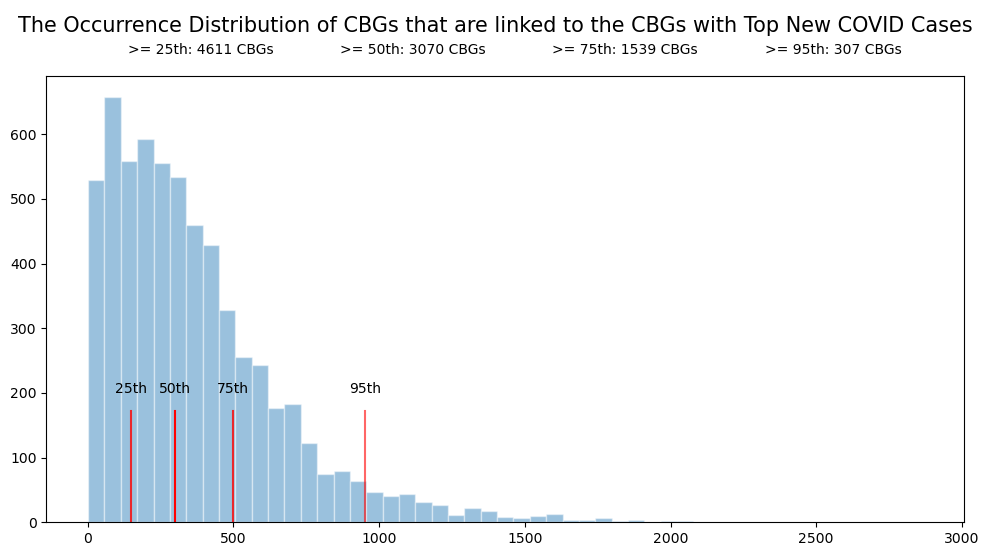

In [23]:
overall_cbgs = []
for timestep in timesteps:
    overall_cbgs += candidate_cbgs[timestep]

index = []
occ = []
for i in Counter(overall_cbgs).most_common():
#for i in Counter(case_cbgs).most_common():
    index.append(i[0])
    occ.append(i[1])
    
vals = pd.Series(occ, index=index)

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(vals, density=False, alpha=0.45, edgecolor='white', bins='scott')

quant_25, quant_50, quant_75, quant_95 = vals.quantile(0.25), vals.quantile(0.5), vals.quantile(0.75), vals.quantile(0.95)
quants = [[quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha=i[1], ymax=0.25, color='red')

ts = 10
ax.text(quant_25, 200, "25th", size=ts, horizontalalignment='center')
ax.text(quant_50, 200, "50th", size=ts, horizontalalignment='center')
ax.text(quant_75, 200, "75th", size=ts, horizontalalignment='center')
ax.text(quant_95, 200, "95th", size=ts, horizontalalignment='center')
#ax.grid()

p25 = mpatches.Patch(color='white')
p50 = mpatches.Patch(color='white')
p75 = mpatches.Patch(color='white')
p95 = mpatches.Patch(color='white')

fig.legend([p25, p50, p75, p95],
                   [f'>= 25th: {vals[vals >= quant_25].shape[0]} CBGs', 
                    f'>= 50th: {vals[vals >= quant_50].shape[0]} CBGs', 
                    f'>= 75th: {vals[vals >= quant_75].shape[0]} CBGs',
                    f'>= 95th: {vals[vals >= quant_95].shape[0]} CBGs'],
                   loc="center",
                   ncol=4,
                   bbox_to_anchor=(0.5, 1.05), 
                   title_fontsize=15,
                   title=f"The Occurrence Distribution of CBGs that are linked to the CBGs with Top New COVID Cases", 
                   edgecolor="white")

fig.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, "nyc-spreader-cbg-histogram-hotspot.pdf"), bbox_inches="tight")

In [24]:
spreader_pct_rank = pd.DataFrame(vals).reset_index()
spreader_pct_rank.columns = ['cbg', 'freq']
spreader_pct_rank['rank'] = spreader_pct_rank['freq'].rank(pct=True)
spreader_pct_rank.to_csv(join(pwd, util_datasets, 'nyc_spreader_rank_1.csv'), index=False)

# vv = pd.DataFrame(vals).reset_index()
# vv.columns = ['cbg', 'freq']
# vv.to_csv(join(pwd, util_datasets, 'nyc_spreader_freq.csv'), index=False)

# Borough vs Bridges 

In [25]:
census_quartiles, census_raw_values = get_census_attrs()

In [26]:
census_quartiles[census_quartiles['census_block_group'].astype(str).str.startswith('36085')]['income-quartile'].value_counts(normalize=True)

Top       0.475694
Second    0.329861
Third     0.128472
Bottom    0.065972
Name: income-quartile, dtype: float64

In [27]:
reg_dir = join(RESULT_SAVE_DIR, 'hotspot')
if not os.path.exists(reg_dir):
    os.makedirs(reg_dir)

In [38]:
from stargazer.stargazer import Stargazer

occ_df = pd.DataFrame(vals, columns=['freq-count'])
occ_df['borough'] = list(map(lambda x: nyc_fips2borough[int(x[:5])], vals.index))
occ_df = pd.get_dummies(occ_df, columns=['borough'], prefix='', prefix_sep='')
occ_df['freq-rank'] = occ_df['freq-count'].rank(pct=True)

result = sm.OLS(occ_df['freq-rank'], occ_df[list(nyc_borough2fips.keys())], missing='drop').fit()
#print(result.summary().as_latex())
#result.summary()

st = Stargazer([result])
st.dependent_variable_name('Occurrence Frequency')
print(st.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: Occurrence Frequency}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 Bronx & 0.631$^{***}$ \\
& (0.008) \\
 Brooklyn & 0.447$^{***}$ \\
& (0.006) \\
 Manhattan & 0.275$^{***}$ \\
& (0.007) \\
 Queens & 0.555$^{***}$ \\
& (0.006) \\
 Staten Island & 0.901$^{***}$ \\
& (0.014) \\
\hline \\[-1.8ex]
 Observations & 6139 \\
 $R^2$ & 0.261 \\
 Adjusted $R^2$ & 0.261 \\
 Residual Std. Error & 0.248 (df=6134) \\
 F Statistic & 542.452$^{***}$ (df=4; 6134) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [19]:
census_quartiles['election'] = 1
census_quartiles.loc[census_quartiles.census_block_group.astype(str).str[:5] == '36085', 'election'] = 0

In [128]:
feature_names = ['income-quartile', 'white_population-quartile', 'black_population-quartile', 'asian_population-quartile',
                'hispanic_population-quartile', 'education-quartile', 'mean_time_to_work-quartile']

qnumeric = {'Top': 4, 'Second': 3, 'Third': 2, 'Bottom': 1}
vec = census_quartiles[census_quartiles['census_block_group'].isin(vals.index)][feature_names].reset_index(drop=True)
vec.replace(qnumeric, inplace=True)

vec = pd.DataFrame(stats.zscore(vec.values, nan_policy='omit'), columns=feature_names)
y = pd.Series(stats.zscore(vals.values, nan_policy='omit'), name='Hotspot Occurrences')
X = sm.add_constant(vec)
result = sm.OLS(y, X, missing='drop').fit()

with open(join(reg_dir, 'hotspot-occurrences-allfeatures-nonSI-noelection.txt'), 'w') as f:
    f.write(result.summary().as_text())

In [101]:
for feature in feature_names:
    qnumeric = {'Top': 4, 'Second': 3, 'Third': 2, 'Bottom': 1}
    vec = census_quartiles[census_quartiles['census_block_group'].isin(vals.index)][[feature]].reset_index(drop=True)
    if feature != 'election':
        vec = vec.replace(qnumeric)

    X = sm.add_constant(vec)
    y = vals.rename('Hotspot Occurrences').reset_index(drop=True)
    result = sm.OLS(y, X, missing='drop').fit()

    with open(join(reg_dir, f'hotspot-occurrences-{feature}-nonSI.txt'), 'w') as f:
        f.write(result.summary().as_text())

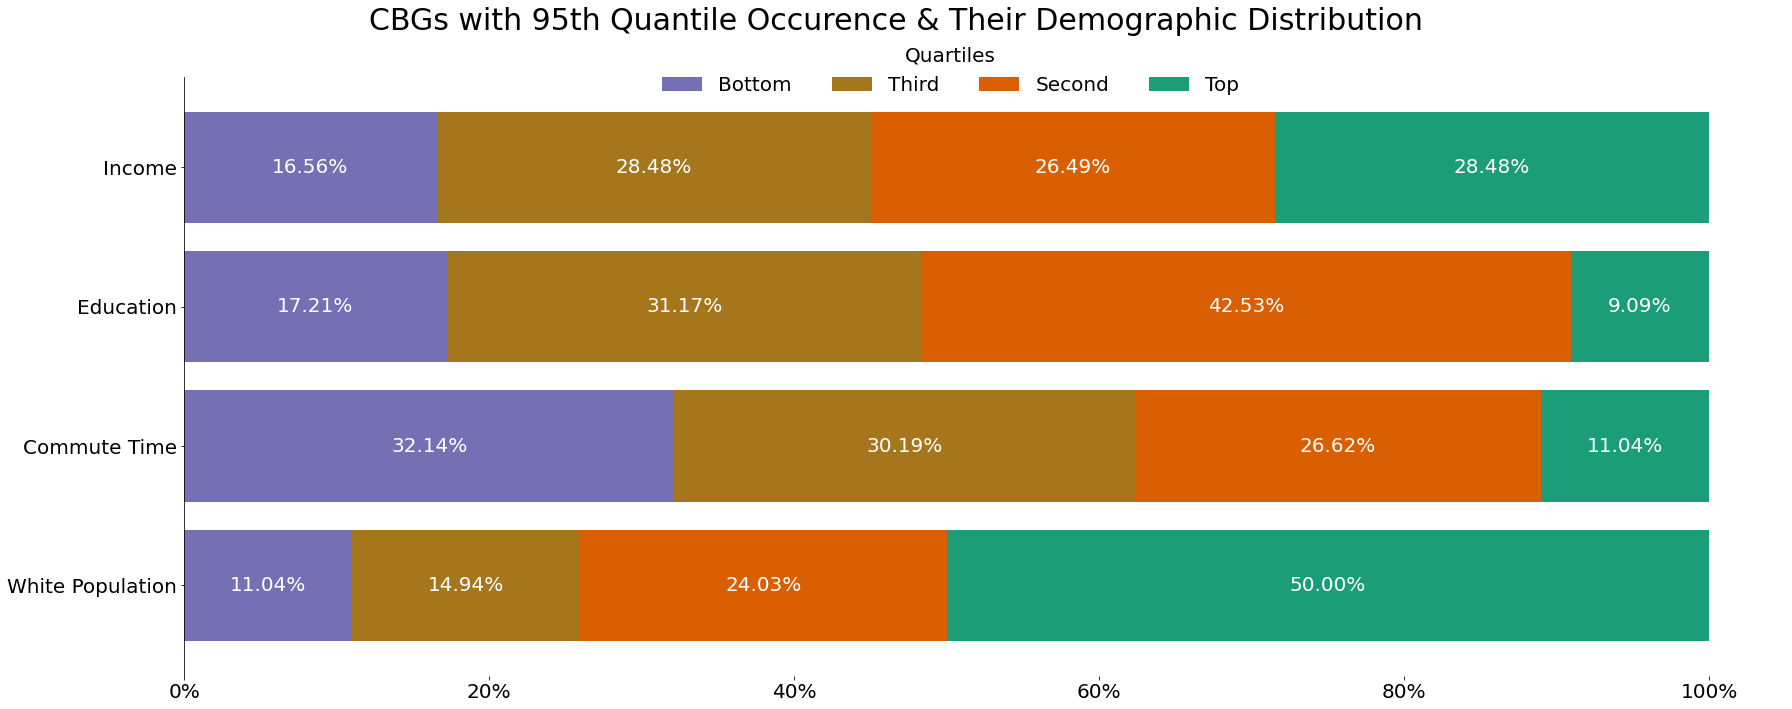

In [35]:
fig, ax = plt.subplots(figsize=(25, 10))

top_color = '#1b9e77'
second_color = '#d95f02'
third_color = '#a6761d'
bottom_color = '#7570b3'

quartile_cols = np.array([['white_population', 'White Population'], ['mean_time_to_work', 'Commute Time'] , ['education', 'Education'], ['income', 'Income']])

agg = census_quartiles[census_quartiles['census_block_group'].isin(vals[vals >= quant_95].index)][[f'{i}-quartile' for i in quartile_cols[:, 0]]].apply(pd.Series.value_counts).T
agg = agg.div(agg.sum(axis=1), axis=0)
agg.plot.barh(stacked=True, ax=ax, legend=False, align='center', width=0.8, color=[bottom_color, third_color, second_color, top_color])

for ind, feature in enumerate(agg.index):
    for cind, quart in enumerate(agg.columns):
        display_value = agg.loc[feature, quart]
        xloc = (agg.iloc[ind, :cind].sum() + agg.iloc[ind, :cind+1].sum()) / 2
        ax.text(xloc, ind, f'{display_value*100:.2f}%', horizontalalignment='center', verticalalignment='center', fontsize=20, color='white')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.set_yticklabels(quartile_cols[:, 1])
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.grid(axis='x', color='white')
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(bbox_to_anchor=(0.67, 1.08), ncol=4, title='Quartiles', edgecolor='white', fontsize=20, title_fontsize=20)
fig.suptitle(f'CBGs with 95th Quantile Occurence & Their Demographic Distribution', fontsize=30)
plt.tight_layout()
#fig.savefig(join(FIG_SAVE_DIR, f'nyc-quant-{95}-demo.pdf'), dpi=900, bbox_inches='tight')

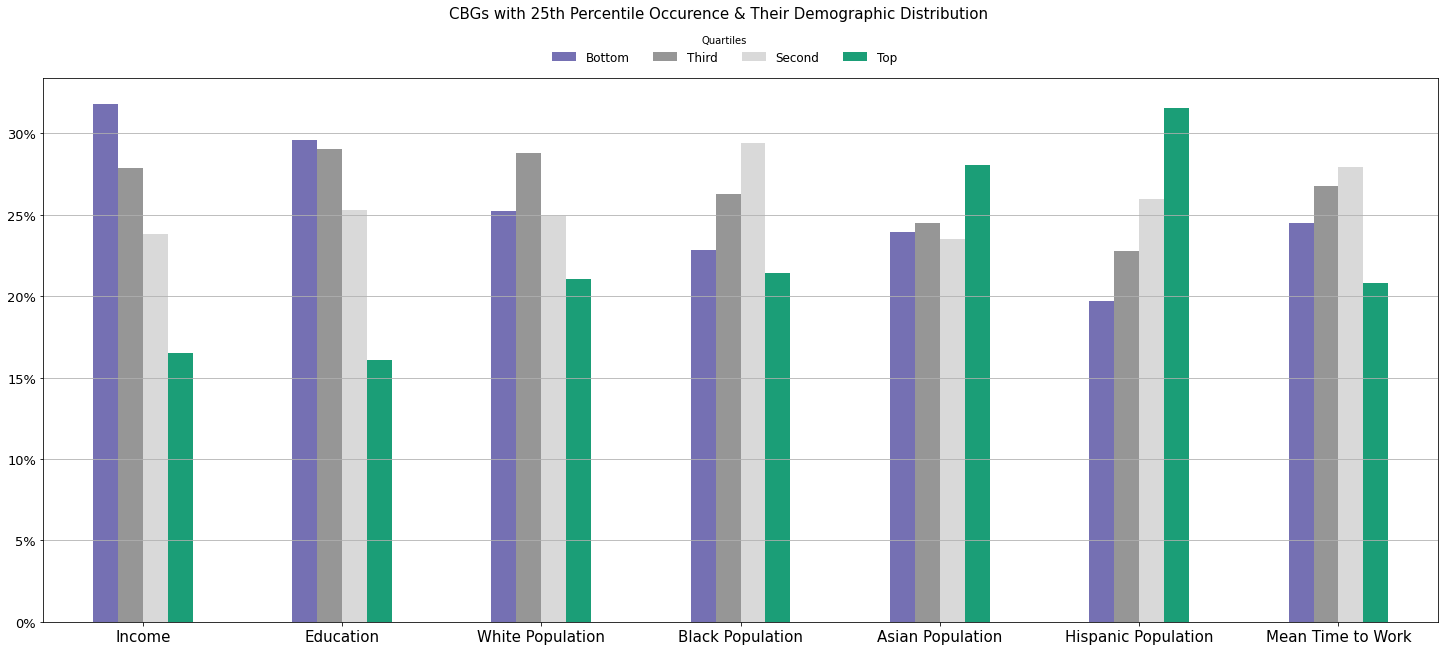

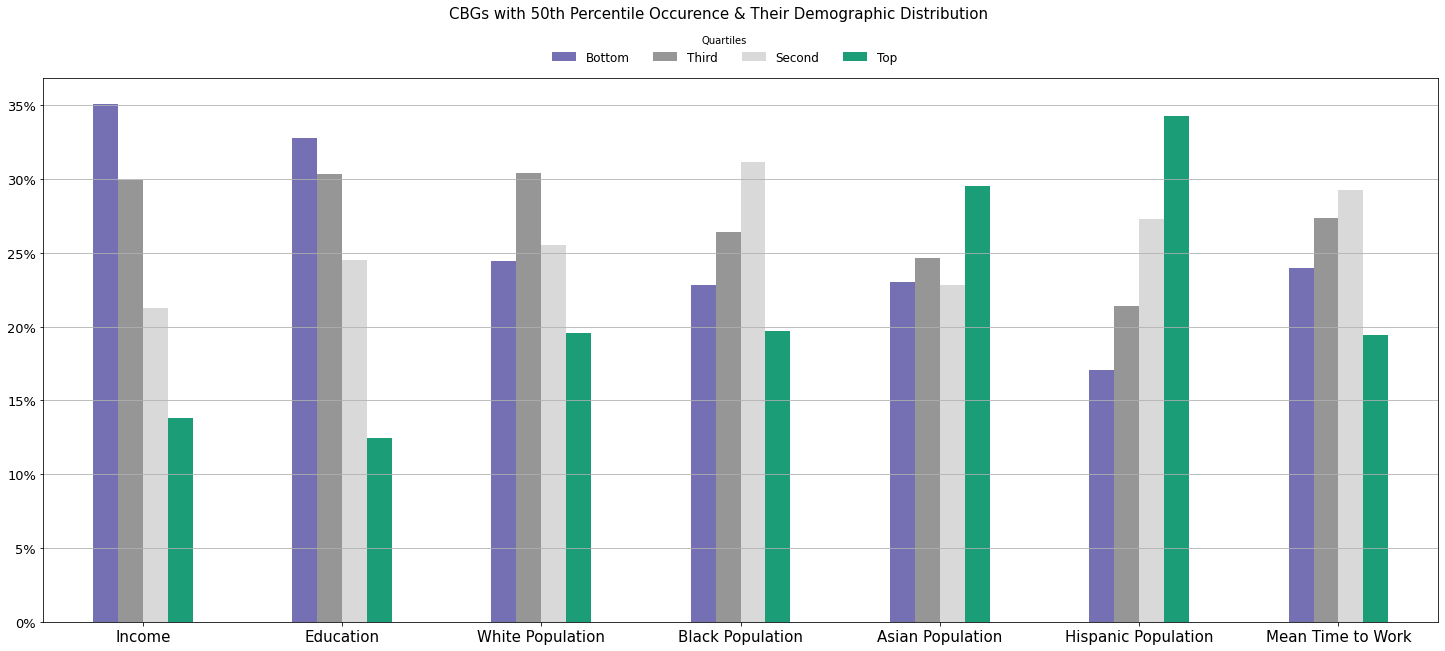

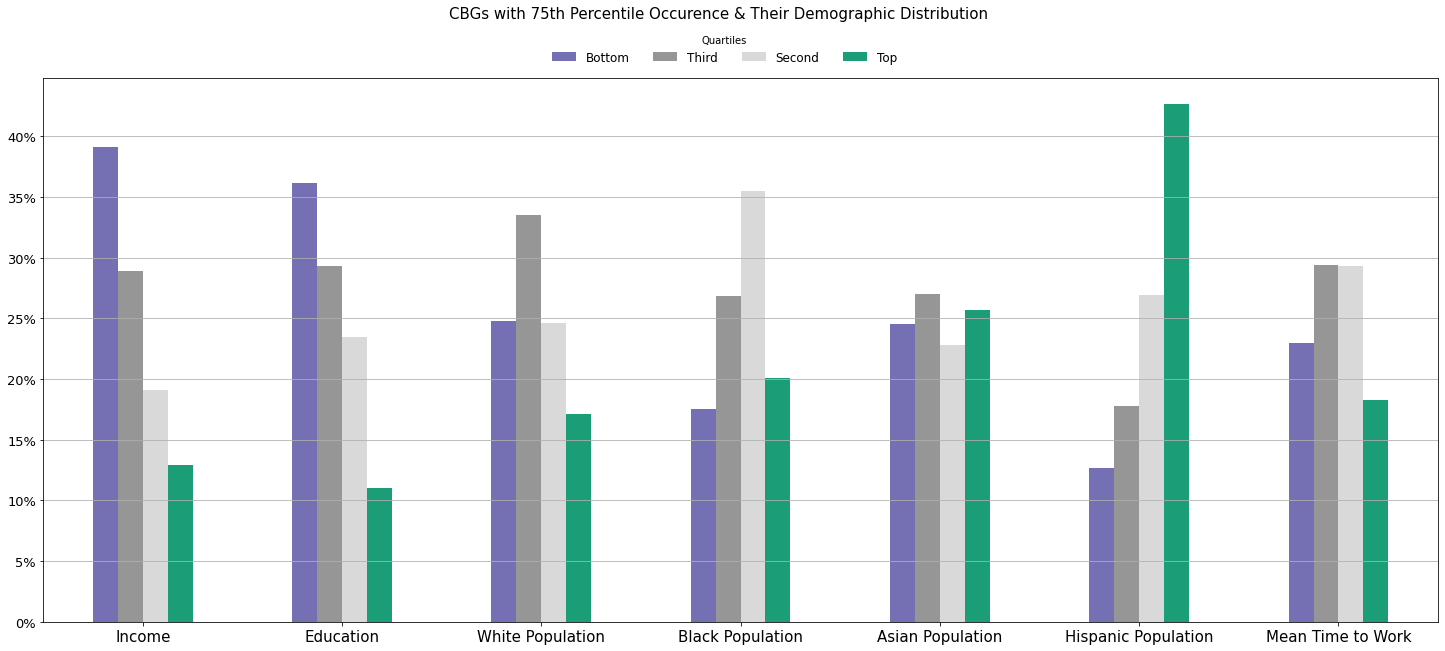

In [44]:
top_color = '#1b9e77'
bottom_color = '#7570b3'

pct_lst = [
    ('25th', quant_25),
    ('50th', quant_50), 
    ('75th', quant_75), 
#     ('95th', quant_95)
]

for pct_name, pct in pct_lst:
    fig, ax = plt.subplots(figsize=(25, 10))
    #quartile_cols = [i for i in census_quartiles.columns if '-quartile' in i]
    quartile_cols = ['income-quartile', 'education-quartile', 'white_population-quartile', 'black_population-quartile', 'asian_population-quartile',
    'hispanic_population-quartile', 'mean_time_to_work-quartile']
    agg = census_quartiles[census_quartiles['census_block_group'].isin(vals[vals >= pct].index)][quartile_cols].apply(pd.Series.value_counts).T
    agg = agg.div(agg.sum(axis=1), axis=0)
    agg.plot.bar(ax=ax, width=0.5, rot=0, color=[bottom_color, '#969696', '#d9d9d9', top_color])
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    ax.grid(axis='y')
    # remove
    ax.set_xticklabels(['Income', 'Education', 'White Population', 'Black Population', 'Asian Population', 'Hispanic Population', 'Mean Time to Work'])
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.legend(bbox_to_anchor=(0.62, 1.1), ncol=4, title='Quartiles', edgecolor='white', fontsize=12)
    fig.suptitle(f'CBGs with {pct_name} Percentile Occurence & Their Demographic Distribution', fontsize=15)
    fig.savefig(join(FIG_SAVE_DIR, f'nyc-quant-{pct_name}-CASES.png'), bbox_inches='tight')

In [75]:
nyc_cbg_shp = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-cbgs.json'))
nyc_zcta_shp = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-borough.geojson'))

In [76]:
staten_island = set(nyc_cbg_shp[nyc_cbg_shp['COUNTYFP'] == '085']['GEOID'].values)

In [22]:
pd.DataFrame(list(staten_island), columns=['cbgs']).to_csv(join(pwd, 'util_datasets', 'staten_island_cbgs.csv'), index=False)

In [77]:
q75_cbg = nyc_cbg_shp[nyc_cbg_shp['GEOID'].astype(np.int64).isin(vals[vals >= quant_75].index)]['GEOID']
q95_cbg = nyc_cbg_shp[nyc_cbg_shp['GEOID'].astype(np.int64).isin(vals[vals >= quant_95].index)]['GEOID']

In [78]:
si_cbg_count = nyc_cbg_shp[nyc_cbg_shp.BLKGRPCE != '0'][nyc_cbg_shp['GEOID'].astype(str).str.startswith('36085')].shape[0]

q75_count = q75_cbg.str.startswith('36085').sum()
q95_count = q95_cbg.str.startswith('36085').sum()

In [79]:
q75_count/si_cbg_count, q95_count/si_cbg_count

(0.0, 0.0)

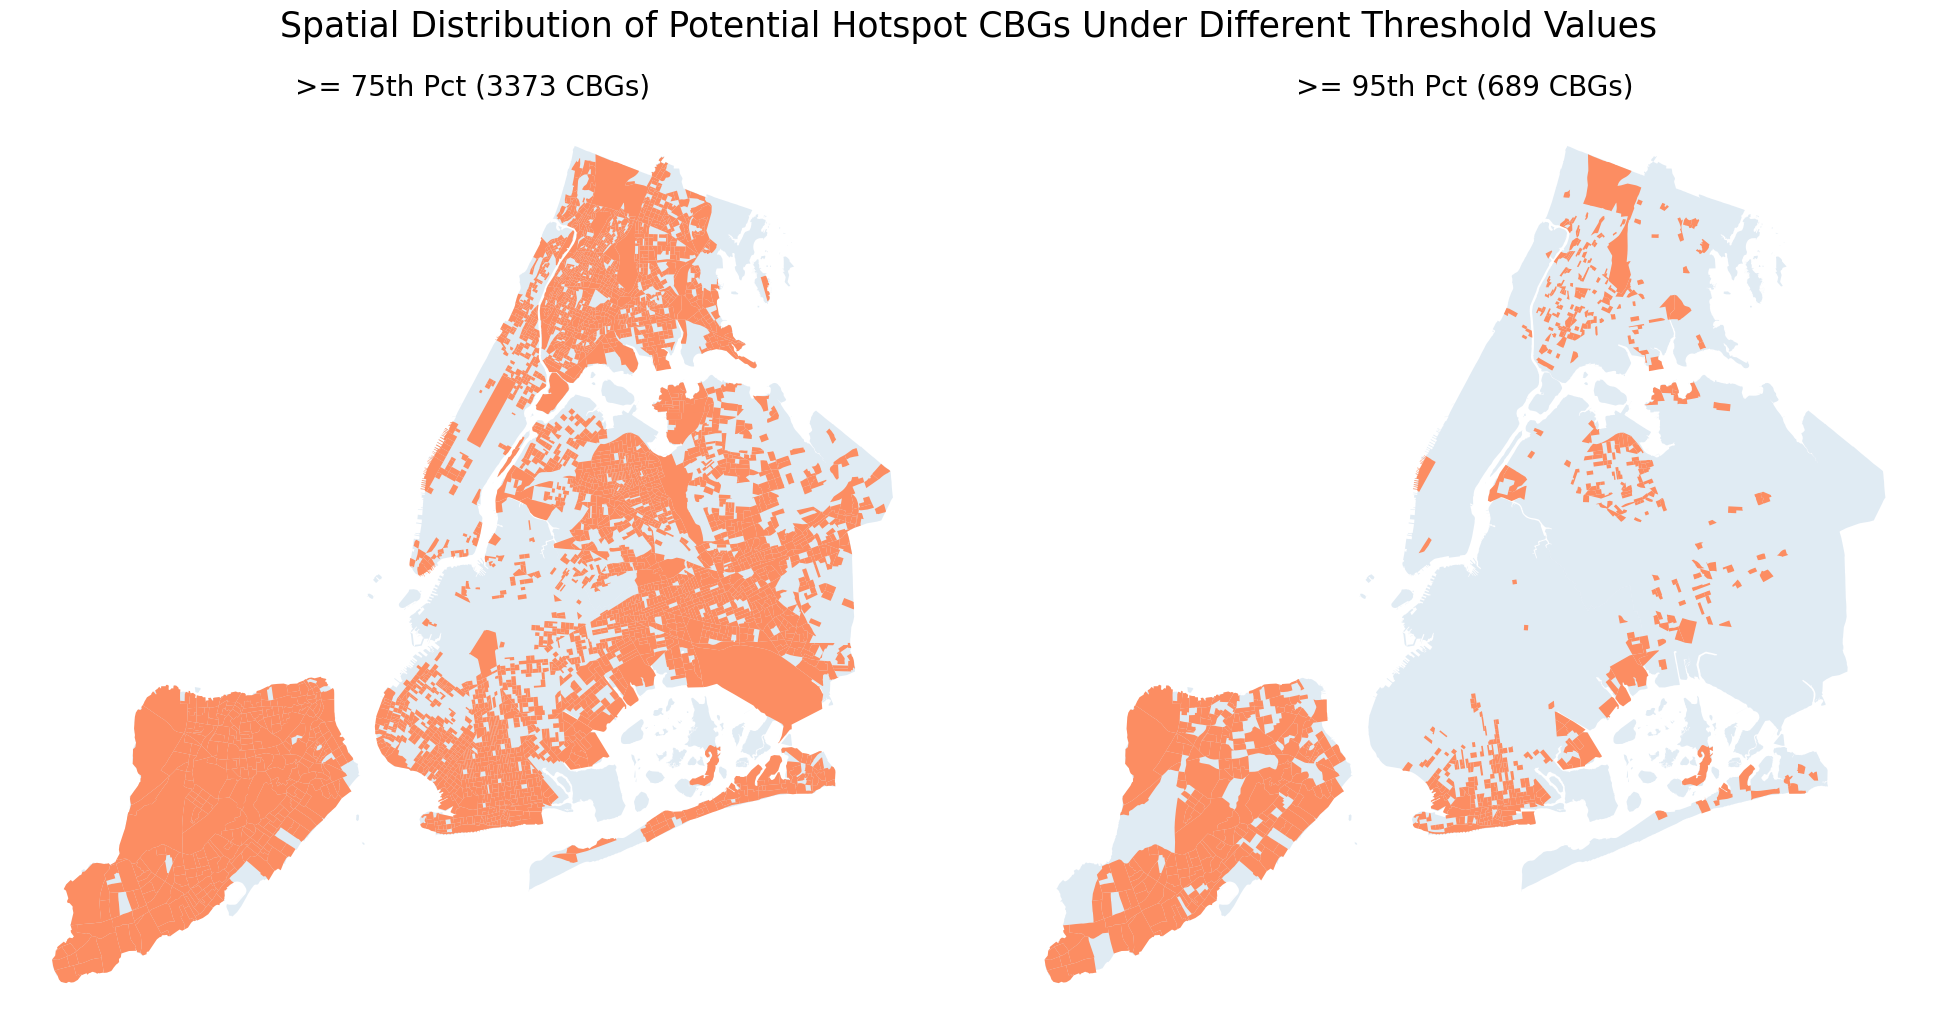

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

base = '#b3cde3'
foreground = '#fc8d62'
alpha = 0.4

ax = axes[0]
nyc_zcta_shp.plot(ax=ax, color=base, alpha=alpha)
p75 = nyc_cbg_shp[nyc_cbg_shp['GEOID'].astype(str).isin(vals[vals >= quant_75].index)]
p75.plot(ax=ax, color=foreground)
ax.axis('off')
ax.set_title(f'>= 75th Pct ({p75.shape[0]} CBGs)', fontsize=20)

ax = axes[1]
nyc_zcta_shp.plot(ax=ax, color=base, alpha=alpha)
p95 = nyc_cbg_shp[nyc_cbg_shp['GEOID'].astype(str).isin(vals[vals >= quant_95].index)]
p95.plot(ax=ax, color=foreground)
ax.axis('off')
ax.set_title(f'>= 95th Pct ({p95.shape[0]} CBGs)', fontsize=20)

fig.suptitle('Spatial Distribution of Potential Hotspot CBGs Under Different Threshold Values', fontsize=25, y=1.03)
fig.tight_layout()
#fig.savefig(join(FIG_SAVE_DIR, 'nyc-quant-map-all-hotspots.pdf'), bbox_inches='tight', dpi=150)

In [15]:
poi_df = pd.read_csv(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-POI-INFO.csv'))
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.longitude, poi_df.latitude))

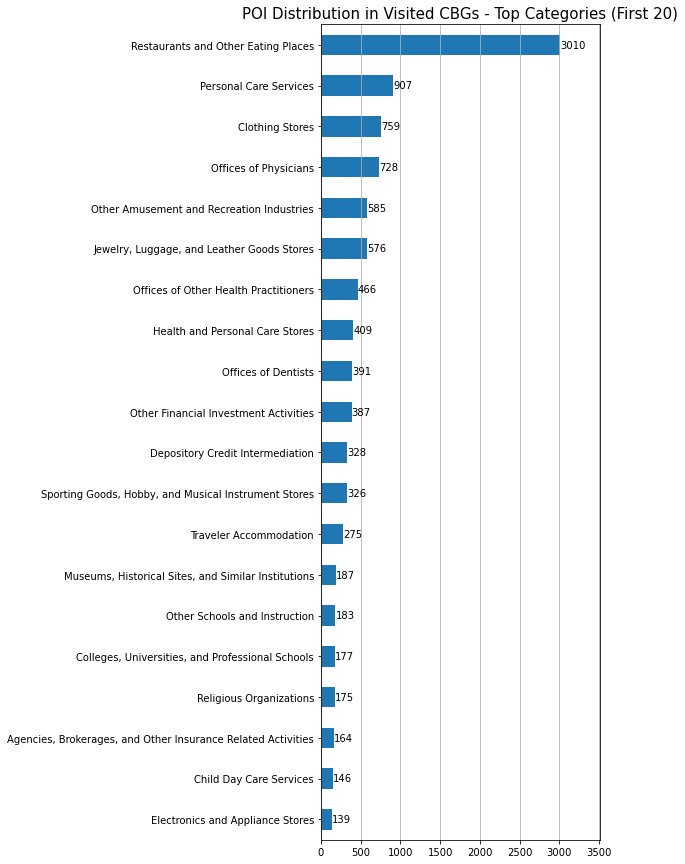

In [75]:
sel_reg = nyc_cbg_shp[nyc_cbg_shp['GEOID'].astype(np.int64).isin(vals[vals >= quant_95].index)]
poi_agg = gpd.sjoin(gdf, sel_reg, how='inner', op='within')['top_category'].value_counts(normalize=False)[::-1]
ax = poi_agg[-20:].plot.barh(figsize=(5, 15))
ax.grid(axis='x')
ax.set_xlim(0, poi_agg.max()+500)
ax.set_title('POI Distribution in Visited CBGs - Top Categories (First 20)', fontsize=15)

for i, val in enumerate(poi_agg[-20:]):
    ax.text(val, i, str(val), verticalalignment='center')
    
fig.savefig(join(FIG_SAVE_DIR, 'nyc-spreader-outflow-poi-dist.png'), bbox_inches='tight')

In [34]:
tmetric = datetime(2020, 2, 24)
tnets = nets[nets[:, 0] >= tmetric]

quart = ['Bottom', 'Third', 'Second', 'Top']

qcbgs = set(vals[vals >= quant_75].index.astype(str))

cent_metrics = [
    ('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True}), 
    ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True}), 
    ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    ('In-Degree', 'in', None),
    ('Out-Degree', 'out', None),
    ('Total-Degree', 'all', None),
    ('Self-Visit-Ratio', 'self', None)
]

results = []
for tp in tqdm(tnets):
    date = tp[0]
    tnet = tp[1]
    common_cbgs = qcbgs.intersection(set(tnet.vs['name']))
    for cent_metric_name, metric, params in cent_metrics:
        if not isinstance(metric, str) and params:
            values = np.array(metric(tnet, **params))
        elif isinstance(metric, str) and not params:
            if metric != 'self':
                values = tnet.strength(loops=False, mode=metric, weights='visits')
            else:
                self_visits = np.subtract(tnet.strength(loops=True, mode='in', weights='visits'), tnet.strength(mode='in', loops=False, weights='visits'))
                out_visits = np.array(tnet.strength(loops=False, mode='out', weights='visits'))
                total_visits = self_visits + out_visits + 0.001

                values = self_visits/total_visits
        data = {
            'date': date,
            'value': values,
            'cbg': tnet.vs['name'],
            'cent_name': cent_metric_name
        }
        net_df = pd.DataFrame(data)
        net_df['value-quartile'] = pd.qcut(net_df['value'].rank(method='first'), q=4, labels=quart)
        results.append(net_df[net_df['cbg'].isin(common_cbgs)])

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [07:45<00:00,  9.90s/it]


In [35]:
grouped_df = pd.concat(results)

In [ ]:
for cent_metric_name, metric, params in cent_metrics:
    _, ax = plt.subplots(figsize=(10, 12))
    tg = grouped_df[grouped_df['cent_name'] == cent_metric_name].groupby(['date'])['value-quartile'].apply(pd.Series.value_counts, normalize=True).unstack()
    tg.index = [d.strftime('%Y-%m-%d') for d in tg.index]
    tg[quart].plot.barh(stacked=True, ax=ax, width=.7, cmap='Set2')

    ax.set_ylabel(None)
    ax.grid(axis='x', color='white')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    plt.legend(bbox_to_anchor=(0.2, 1.02), ncol=4, edgecolor='white', title=f'CBGs >= 75th Pct: {cent_metric_name} Distribution', fontsize=12, title_fontsize=15)
    plt.tight_layout()
    plt.savefig(join(FIG_SAVE_DIR, f'{cent_metric_name}-q75_CASES.png'), bbox_inches='tight')

### Demographic Groups vs Cases

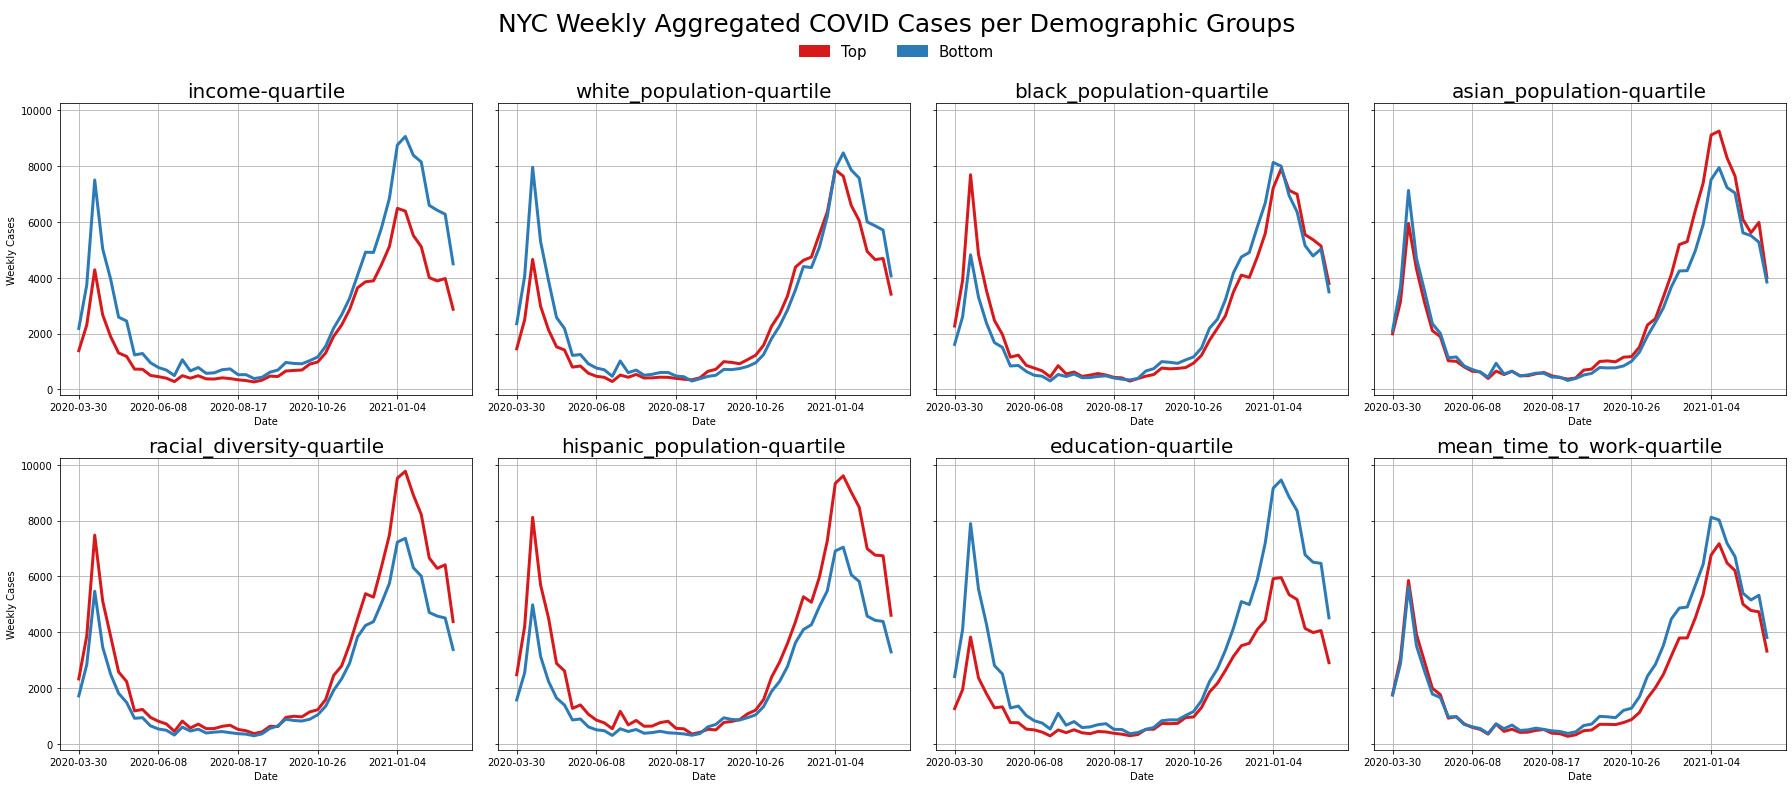

In [11]:
census_quartiles, _ = get_census_attrs()
cols = [col for col in census_quartiles.columns if 'quartile' in col]
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(25, 10))

topc = '#d7191c'
bottomc = '#2c7bb6'

for ax, col in zip(axes.flatten(), cols):
    top_cbg = census_quartiles[census_quartiles[col] == 'Top']
    bottom_cbg = census_quartiles[census_quartiles[col] == 'Bottom']
    
    cases_df[cases_df['cbg'].isin(top_cbg['census_block_group'].values)].groupby('Date').sum()['Norm_Cases'].plot(ax=ax, color=topc, linewidth=3)
    cases_df[cases_df['cbg'].isin(bottom_cbg['census_block_group'].values)].groupby('Date').sum()['Norm_Cases'].plot(ax=ax, color=bottomc, linewidth=3)
    ax.set_title(col, fontsize=20)
    ax.set_ylabel('Weekly Cases')
    ax.grid()
    
top_patch = mpatches.Patch(color=topc)
bottom_patch = mpatches.Patch(color=bottomc)

fig.legend([top_patch, bottom_patch],
                   ['Top', 
                    'Bottom'],
                   loc="center",
                   ncol=2,
                   bbox_to_anchor=(0.5, 1.05), 
                   fontsize=15,
                   title_fontsize=25,
                   title="NYC Weekly Aggregated COVID Cases per Demographic Groups", 
                   edgecolor="white")

fig.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, "nyc-covid-cases-per-demographics-quartiles.png"), bbox_inches="tight")

### Income vs Racial Groups

In [ ]:
census_quartiles, census_raw_values = get_census_attrs()
groups = ['white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
for sattr in groups:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(census_raw_values[sattr], census_raw_values['income'], s=1)
    axes[0].set_xlabel(sattr)
    axes[0].set_ylabel('income')
    coeff = census_raw_values[[sattr, 'income']].corr(method='pearson').values[1,0]
    axes[0].set_title(f'Pearson Coefficient: {coeff:.2f}')

    xr = np.linspace(census_raw_values['income'].min(), census_raw_values['income'].max(), 6)
    lbl = [f'${x / 1000:.0f}K' for x in xr]
    axes[0].set_yticks(xr)
    axes[0].set_yticklabels(lbl)

    tb = pd.crosstab(census_quartiles['income-quartile'], census_quartiles[f'{sattr}-quartile'], normalize='index')
    stats.chi2_contingency(tb)
    tb.plot.bar(ax=axes[1], rot=0)
    axes[1].grid(axis='y')
    axes[1].legend(title=f'{sattr} - Quartiles', bbox_to_anchor=(1,1))
    axes[1].set_xlabel('income - Quartile')
    axes[1].set_ylabel('Share')

    yr = np.linspace(0, tb.values.max(), 6)
    lbl = [f'{y*100:.0f}%' for y in yr]
    axes[1].set_yticks(yr)
    axes[1].set_yticklabels(lbl);

    fig.savefig(join(FIG_SAVE_DIR, f'{sattr}-income-corr.png'), bbox_inches='tight');

### Network Summaries

In [339]:
n_edges = []
mean_in_deg = []
mean_out_deg = []
mean_total_deg = []
mean_wdeg = []
diameter = []
clustering_coef = []
mean_path_len = []
density = []
local_clustering = []
for net in tqdm(nets):
    n_edges.append(len(net[1].es))
    mean_in_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='in')))
    mean_out_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='out')))
    mean_total_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')))
    mean_wdeg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')) / len(net[1].vs))
    diameter.append(ig.Graph.diameter(net[1], directed=True, unconn=net[1].is_connected()))
    density.append(ig.Graph.density(net[1], loops=True))
    clustering_coef.append(ig.Graph.transitivity_undirected(net[1]))
    mean_path_len.append(ig.Graph.average_path_length(net[1], directed=True, unconn=net[1].is_connected()))
    local_clustering.append(np.nanmean(ig.Graph.transitivity_local_undirected(net[1], weights='weight')))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [06:00<00:00,  3.37s/it]


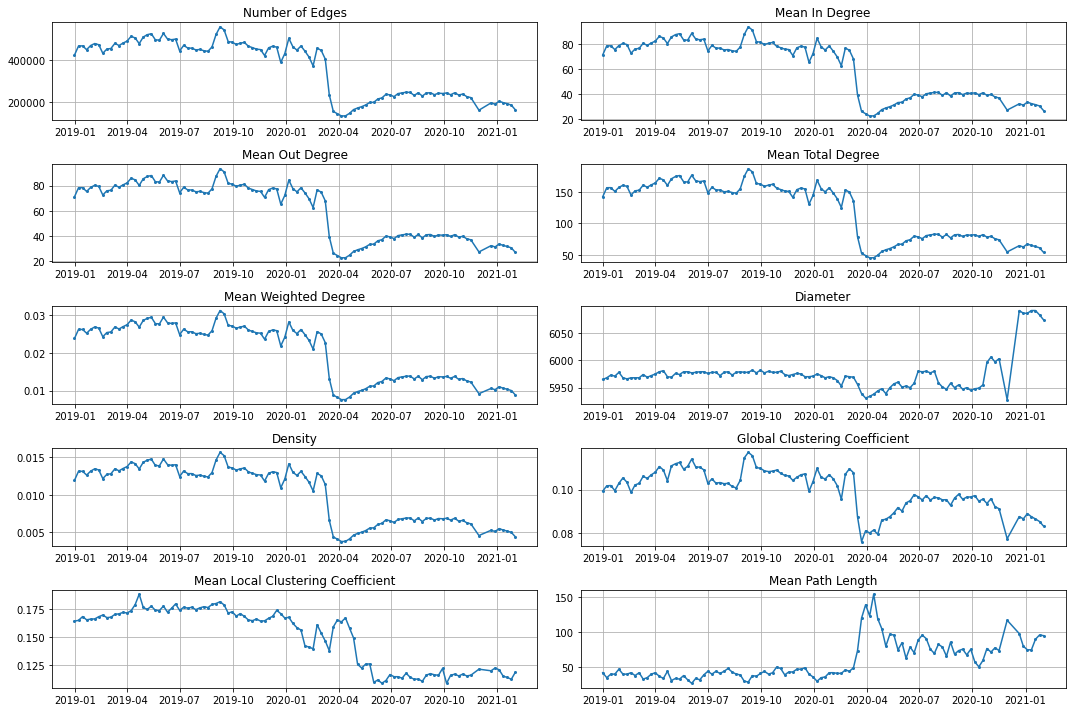

In [350]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

arrays = [
    (n_edges, 'Number of Edges'),
    (mean_in_deg, 'Mean In Degree'),
    (mean_out_deg, 'Mean Out Degree'),
    (mean_total_deg, 'Mean Total Degree'),
    (mean_wdeg, 'Mean Weighted Degree'),
    (diameter, 'Diameter'),
    (density, 'Density'),
    (clustering_coef, 'Global Clustering Coefficient'),
    (local_clustering, 'Mean Local Clustering Coefficient'),
    (mean_path_len, 'Mean Path Length'),
]

# time steps
dx = [net[0] for net in nets]

for i, ax in enumerate(axes.flatten()):
    ax.plot(dx, arrays[i][0], marker='o', markersize=2)
    ax.set_title(arrays[i][1])
    ax.grid()
    
plt.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, f'{AREA_NAME}-net-summary.png'), bbox_to_inches='tight')

### Temporal Change in Centrality Metrics by Demographic Groups 

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [12]:
def change_sign(val):
    '''
    returns the sign of the change
    '''
    if np.abs(val) <= 0.5:
        return 'neutral'
    elif val > 0:
        return 'positive'
    else:
        return 'negative'

In [13]:
def get_metric_change_df(t1, t2, attribute_df):
    '''
    calculates the centrality metrics and assings the values to the CBGs
    at the end, merges with the provided attribute df
    '''
    cent_metrics = [
        ('Closeness', ig.Graph.closeness, {'cutoff': -1, 'normalized': True}), 
        ('Betweenness', ig.Graph.betweenness, {'cutoff': -1, 'directed': True}), 
        ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True})
    ]

    ts_source = datetime.strptime(t1, '%Y-%m-%d')
    ts_target = datetime.strptime(t2, '%Y-%m-%d')

    net_source = nets[nets[:, 0] == ts_source][0,1]
    net_target = nets[nets[:, 0] == ts_target][0,1]
    
    dfs = []
    for cent_metric_name, cent_metric, params in cent_metrics:
        source_vals = np.array(cent_metric(net_source, **params))
        target_vals = np.array(cent_metric(net_target, **params))

        source_data = {
            'source_value': source_vals,
            'CBG': net_source.vs['name']
        }

        target_data = {
            'target_value': target_vals,
            'CBG': net_target.vs['name']
        }

        source_df = pd.DataFrame(source_data)
        target_df = pd.DataFrame(target_data)

        r = pd.merge(source_df, target_df, on="CBG", how='inner')
        r[f'{cent_metric_name}_relative_change'] = (r['target_value'] - r['source_value']) / r['source_value'] * 100
        r[f'{cent_metric_name}_change_sign'] = r[f'{cent_metric_name}_relative_change'].apply(change_sign)
        r['CBG'] = r['CBG'].astype(np.int64)
        d = pd.merge(attribute_df, r, left_on='census_block_group', right_on='CBG', how='inner')
        dfs.append((cent_metric_name, d))
        
    return dfs

### Centrality Metrics vs COVID Cases 

In [ ]:
tmetric = datetime(2020, 3, 30)
tcase = tmetric + timedelta(days=7*2)

tnet = nets[nets[:, 0] == tmetric][0,1]
tcbgs = cases_df[cases_df.Date == tcase.strftime('%Y-%m-%d')]

quart = ['Bottom', 'Third', 'Second', 'Top']
tcbgs['cases-quartile'] = pd.qcut(tcbgs['Norm_Cases'], q=4, labels=quart)

cent_metrics = [
    ('Closeness', ig.Graph.closeness, {'cutoff': -1, 'normalized': True}), 
    ('Betweenness', ig.Graph.betweenness, {'cutoff': -1, 'directed': True}), 
    ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    ('In-Degree', 'in', None),
    ('Out-Degree', 'out', None),
    ('Total-Degree', 'all', None),
    ('Self-Visit-Ratio', 'self', None)
]

results = []
results_norm = []
for cent_metric_name, metric, params in cent_metrics:
    if not isinstance(metric, str) and params:
        values = np.array(metric(tnet, **params))
    elif isinstance(metric, str) and not params:
        if metric != 'self':
            #values = tnet.degree(mode=metric, loops=False)
            values = tnet.strength(loops=False, mode=metric, weights='visits')
        else:
            self_visits = np.subtract(tnet.strength(loops=True, mode='in', weights='visits'), tnet.strength(mode='in', loops=False, weights='visits'))
            out_visits = np.array(tnet.strength(loops=False, mode='out', weights='visits'))
            total_visits = self_visits + out_visits + 0.001

            values = self_visits/total_visits
    else:
        nodes = tnet.vs['name']
        values = []
        for node in nodes:
            v = 0
            if 'In' in cent_metric_name:
                v += sum([i['visits'] for i in tnet.es.select(lambda edge: edge.target_vertex['name'] == node)])
            else:
                v += sum([i['visits'] for i in tnet.es.select(lambda edge: edge.source_vertex['name'] == node)])
            values.append(v)
    data = {
        'value': values,
        'cbg': tnet.vs['name']
    }
    net_df = pd.DataFrame(data)
    net_df['cbg'] = net_df['cbg'].astype(np.int64)
    net_df['value-quartile'] = pd.qcut(net_df['value'], q=4, labels=quart)
    
    merged_df = pd.merge(tcbgs, net_df, on='cbg', how='inner')
    
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))
    
    axes[0].scatter(merged_df['value'], merged_df['Norm_Cases'], s=1)
    axes[0].set_ylabel('Weekly COVID Cases')
    axes[0].set_xlabel(f'{cent_metric_name}')

    axes[1].scatter(np.log(merged_df['value']), np.log(merged_df['Norm_Cases']), s=1)
    axes[1].set_ylabel('Weekly COVID Cases (log)')
    axes[1].set_xlabel(f'{cent_metric_name} (log)')
    coeff = merged_df[['Norm_Cases', 'value']].corr(method='spearman').values[1,0]

    tb = pd.crosstab(merged_df['cases-quartile'], merged_df['value-quartile'], normalize='index')
    tb.plot.bar(ax=axes[2], rot=0)
    axes[2].grid(axis='y')
    axes[2].legend(title=f'{cent_metric_name} - Quartiles', bbox_to_anchor=(1,1))
    axes[2].set_xlabel('Weekly COVID Cases - Quartile')
    axes[2].set_ylabel('Share')

    yr = np.linspace(0, tb.values.max(), 6)
    lbl = [f'{y*100:.0f}%' for y in yr]
    axes[2].set_yticks(yr)
    axes[2].set_yticklabels(lbl);

    fig.suptitle(f'{cent_metric_name} - Weekly COVID Cases: Spearman Coefficient: {coeff:.2f}', fontsize=15)
    plt.tight_layout()
    
    Y_norm = pd.Series(stats.zscore(merged_df['Norm_Cases'].values), name='Norm_Cases')
    X_norm = pd.DataFrame(stats.zscore(merged_df[['value']].values))
    X_norm.columns = ['value']
    
    res = sm.OLS(merged_df['Norm_Cases'], add_constant(merged_df[['value']])).fit() 
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results.append(r)
    
    res = sm.OLS(Y_norm, add_constant(X_norm)).fit()
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results_norm.append(r)
    
    fig.savefig(join(FIG_SAVE_DIR, f'{cent_metric_name}-weekly-covid-cases-corr-{tmetric.strftime("%Y-%m-%d")}-no-loops-visits-self_visit_ratio.png'), bbox_inches='tight');
    
title = 'weekly-covid-cases-reg-centr-metrics-no-loops-visits-self_visit_ratio'
groups = [
    (results, f'{title}.tex'),
    (results_norm, f'{title}-norm.tex')
]
for res, fname in groups:
    with pd.option_context('display.float_format', '{:.3f}'.format):
        with open(join(RESULT_SAVE_DIR, fname), 'w') as tablef:
            tablef.write(pd.concat(res).groupby(['Centrality Metric', 'R2-Adj', 'Attribute']).sum().to_latex(bold_rows=True, multirow=True))

### Regression Model btw Relative Centrality Changes & Demographical Attributes 

#### Between Two Dates

In [23]:
t1 = '2020-01-13'
t2 = '2020-06-08'
dfs = get_metric_change_df(t1, t2, census_attrs_features)

In [24]:
features = ['income', 'white_population', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

for metric_name, df in dfs:
    df = df.dropna()
    
    res = sm.OLS(df[f'{metric_name}_relative_change'], df[features]).fit()
    with open(join(RESULT_SAVE_DIR, f'{metric_name}-{t1}-{t2}-ols-results-income-excluded.txt'), 'w') as f:
        f.write(res.summary().as_text())

#### Average of Jan-Feb-March & Apr-May-Jun

In [18]:
census_quartiles, census_raw_values = get_census_attrs(rank_list=['income'])

In [19]:
# Jan-Feb-March & Apr-May-Jun networks
grouped_nets = nets[(nets[:, 0] >= datetime(2020, 1, 1)) & (nets[:, 0] < datetime(2020, 7, 1))]
# first case
mid = np.where(grouped_nets[:, 0] == datetime(2020, 3, 9))[0][0]

# find the cbgs that exists in all networks
cbgs = []
for ind in range(len(grouped_nets)):
    cbgs.append(grouped_nets[ind, 1].vs['name'])
    
cbgs = reduce(np.intersect1d, cbgs)
cbg_attrs = census_raw_values.set_index('census_block_group').loc[cbgs.astype(np.int64)].dropna()
cbgs = cbg_attrs.index.values.astype(str)

### VIF

In [37]:
features = ['income', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']
norm = census_attrs_features[features].dropna()
norm = pd.DataFrame(stats.zscore(norm.values))
norm.columns = features

vif_data = pd.DataFrame() 
vif_data["feature"] = norm.columns
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(norm.values, i) 
                          for i in range(len(norm.columns))] 
vif_data.to_csv(join(RESULT_SAVE_DIR, 'vif-white-removed-norm.csv'), index=False)
vif_data

,feature,VIF
0,income,2.268127
1,black_population,1.882548
2,asian_population,1.457281
3,hispanic_population,1.855393
4,education,2.795531
5,mean_time_to_work,1.289685


In [20]:
features = ['income', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

cent_metrics = [
    ('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True}), 
    ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True}), 
    ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    ('In-Degree', 'in', None),
    ('Out-Degree', 'out', None),
    ('Total-Degree', 'all', None)
]

title = 'white-removed-ranked-income-no-loops-visits'
results = []
results_norm = []
for cent_metric_name, metric, params in cent_metrics:
    net_dfs = []
    for timestamp, net in tqdm(grouped_nets):
        if not isinstance(metric, str) and params:
            values = np.array(metric(net, **params))
        elif isinstance(metric, str) and not params:
            #values = net.degree(mode=metric, loops=False)
            values = net.strength(loops=False, mode=metric, weights='visits')
        else:
            nodes = net.vs['name']
            values = []
            for node in nodes:
                v = 0
                if 'In' in cent_metric_name:
                    v += sum([i['visits'] for i in net.es.select(lambda edge: edge.target_vertex['name'] == node)])
                else:
                    v += sum([i['visits'] for i in net.es.select(lambda edge: edge.source_vertex['name'] == node)])
                values.append(v)
        data = {
            'value': values,
            'CBG': net.vs['name']
        }
        net_df = pd.DataFrame(data).set_index('CBG')
        net_dfs.append(net_df.loc[cbgs, 'value'].values)

    net_dfs = np.array(net_dfs)
    # Jan-Feb-March
    g1 = net_dfs[:mid]
    mean_vals_g1 = g1.mean(axis=0)
    # Apr-May-Jun
    g2 = net_dfs[mid:]
    mean_vals_g2 = g2.mean(axis=0)

    # compute relative change
    rel_chg = (mean_vals_g2 - mean_vals_g1) / mean_vals_g1 * 100

    res = sm.OLS(pd.Series(rel_chg, name=f'{cent_metric_name} Relative Change, Jan-Feb-March vs Apr-May-Jun', index=cbg_attrs.index), add_constant(cbg_attrs[features])).fit()
    
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results.append(r)
    
    with open(join(RESULT_SAVE_DIR, f'{cent_metric_name}-ols-results-three-months-{title}.txt'), 'w') as f:
        f.write(res.summary().as_text())
        
    X_norm = pd.DataFrame(stats.zscore(cbg_attrs[features].values), index=cbg_attrs.index)
    X_norm.columns = features
    
    res = sm.OLS(pd.Series(stats.zscore(rel_chg), name=f'{cent_metric_name} Relative Change, Jan-Feb-March vs Apr-May-Jun', index=cbg_attrs.index), 
                 add_constant(X_norm)).fit()
    
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results_norm.append(r)
        
    with open(join(RESULT_SAVE_DIR, f'{cent_metric_name}-ols-results-three-months-{title}-norm.txt'), 'w') as f:
        f.write(res.summary().as_text())
    
title = 'white-removed-ranked-income-no-loops-visits'
groups = [
    (results, f'{title}.tex'),
    (results_norm, f'{title}-norm.tex')
]
for res, fname in groups:
    with pd.option_context('display.float_format', '{:.3f}'.format):
        with open(join(RESULT_SAVE_DIR, fname), 'w') as tablef:
            tablef.write(pd.concat(res).groupby(['Centrality Metric', 'R2-Adj', 'Attribute']).sum().to_latex(bold_rows=True, multirow=True))

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.66it/s]
